In [2]:
import geopandas
import pyproj

proj_str = '+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs'

taxi_zones = geopandas.read_file('../data/taxi_zones.dbf')
streets = geopandas.read_file('../data/geo_export_1bd89f7a-c99b-46a2-91f5-4fac331bbd32.dbf')

In [3]:
from functools import partial
from shapely.ops import transform as shapely_transform

proj_src = pyproj.Proj(proj_str, preserve_units=True)
proj_dst = pyproj.Proj(init="epsg:4326")
proj_func = partial(pyproj.transform, proj_src, proj_dst)

taxi_zones['geometry'] = taxi_zones['geometry'].apply(lambda x: shapely_transform(proj_func, x))

In [4]:
test = streets.query('st_label == "E 157 ST"')[['r_high_hn', 'r_low_hn', 'trafdir', 'geometry']]
test

,r_high_hn,r_low_hn,trafdir,geometry
3932,478,441,TF,LINESTRING (-73.91355330595509 40.821168861804...
9092,28,0,TW,LINESTRING (-73.93023982756259 40.826870623213...
26982,398,355,TF,LINESTRING (-73.91691503456477 40.822202380631...
43545,150,121,TW,LINESTRING (-73.92618100371563 40.825386357613...
45668,498,481,TF,LINESTRING (-73.91257037364859 40.820860844532...
68488,532,511,TW,LINESTRING (-73.91153954013596 40.820181615292...
68736,118,101,TW,LINESTRING (-73.92715291395996 40.825723914255...
79096,None,None,TW,LINESTRING (-73.93068561627994 40.827060599057...
90015,None,None,TW,LINESTRING (-73.91172376897184 40.820213580918...
111602,18,1,TW,LINESTRING (-73.93060310116333 40.827021279256...


In [5]:
for id_, i in test['geometry'].iteritems():
    print(id_, i)

3932 LINESTRING (-73.91355330595509 40.82116886180429, -73.91257037364859 40.82086084453287)
9092 LINESTRING (-73.93023982756259 40.82687062321337, -73.92985605419889 40.82671373137113, -73.92976069276516 40.82658241881357)
26982 LINESTRING (-73.91691503456477 40.82220238063146, -73.91541396133326 40.82174162802169, -73.91518090594553 40.82167008911862)
43545 LINESTRING (-73.92618100371563 40.82538635761376, -73.92539995626355 40.82511462591715)
45668 LINESTRING (-73.91257037364859 40.82086084453287, -73.91167936179608 40.82062539703172)
68488 LINESTRING (-73.91153954013596 40.82018161529211, -73.91035124621581 40.81994819782424)
68736 LINESTRING (-73.92715291395996 40.82572391425548, -73.92618100371563 40.82538635761376)
79096 LINESTRING (-73.93068561627994 40.82706059905738, -73.93060310116333 40.82702127925657)
90015 LINESTRING (-73.91172376897184 40.82021358091832, -73.91153954013596 40.82018161529211)
111602 LINESTRING (-73.93060310116333 40.82702127925657, -73.93023982756259 40.8

In [6]:
print(i)

LINESTRING (-73.91518090594553 40.82167008911862, -73.91355330595509 40.82116886180429)


In [12]:
n_taxi_zones = taxi_zones.shape[0]
taxi_zone_geometry = taxi_zones.geometry

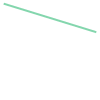

In [21]:
import tqdm
import itertools
import numpy as np
import shapely.geometry as geom

adj_matrix = np.zeros((n_taxi_zones, n_taxi_zones))

for street in tqdm.tqdm_notebook(streets['geometry']):
    src_zone = None
    for coord in street.coords:
        dst_zone = taxi_zone_geometry.contains(geom.Point(coord)).nonzero()[0]
        if len(dst_zone) > 1:
            print(coord, 'appears in', len(dst_zone), 'zones', dst_zone)
        if src_zone is not None:
            for s, d in itertools.product(src_zone, dst_zone):
                if s != d:
                    adj_matrix[s, d] = 1
        src_zone = dst_zone

(-73.93190743894837, 40.65653765254297) appears in 2 zones [70 71]
(-73.91689176370775, 40.841347256649875) appears in 2 zones [118 246]
(-73.99574855573138, 40.749052196220944) appears in 2 zones [ 67 185]
(-74.01634322391006, 40.630285595428546) appears in 2 zones [13 66]
(-74.182067410141, 40.546044838542656) appears in 2 zones [ 4 83]
(-73.99050558603597, 40.73056495623517) appears in 2 zones [ 78 112]
(-73.93453329103372, 40.71275330439045) appears in 2 zones [36 79]
(-73.92621972038896, 40.816758654969234) appears in 2 zones [158 167]
(-73.96853234187864, 40.57630503116181) appears in 2 zones [28 54]
(-74.19912044807853, 40.54670870725512) appears in 2 zones [  4 203]
(-73.84185186550224, 40.86819192487697) appears in 2 zones [ 2 80]
(-73.88658010086996, 40.82266811741025) appears in 2 zones [ 59 125]
(-74.08890387705283, 40.63029199017555) appears in 2 zones [114 244]
(-73.83159620031942, 40.86264470442437) appears in 2 zones [ 2 80]
(-73.83151964286819, 40.86259766919326) appea

(-74.21954309356954, 40.54569938368375) appears in 2 zones [ 43 203]
(-74.1758274969218, 40.60152685299558) appears in 2 zones [22 98]
(-73.8831908876946, 40.88328483400967) appears in 2 zones [173 239]
(-74.06914030987379, 40.60403971822763) appears in 2 zones [  5 220]
(-74.07693910836242, 40.637781614653015) appears in 2 zones [205 220]
(-73.8799579875287, 40.884390628463535) appears in 2 zones [173 239]
(-73.76335501839795, 40.71741138227162) appears in 2 zones [121 130]
(-74.10552598888418, 40.618592329499634) appears in 2 zones [244 250]
(-73.88692889734149, 40.884355714351344) appears in 2 zones [173 239]
(-73.88705142602338, 40.88434957584661) appears in 2 zones [239 240]
(-73.97132526390176, 40.67124822439153) appears in 2 zones [180 189]
(-73.78459339415485, 40.77614122468918) appears in 2 zones [14 15]
(-73.99187102433558, 40.74418557044371) appears in 2 zones [ 89 233]
(-73.91719587454159, 40.61609171591116) appears in 2 zones [ 90 154]
(-73.9119295507378, 40.72945841556751

(-74.00405900803743, 40.71313478975272) appears in 2 zones [ 44 230]
(-73.9070578187741, 40.75867814509597) appears in 2 zones [  6 259]
(-73.82508489285833, 40.84469769785404) appears in 2 zones [ 57 183]
(-74.1559332651583, 40.535353757121136) appears in 2 zones [ 83 108]
(-73.91719587454159, 40.61609171591116) appears in 2 zones [ 90 154]
(-73.860551008348, 40.86552969542543) appears in 2 zones [ 2 31]
(-73.8831908876946, 40.88328483400967) appears in 2 zones [173 239]
(-73.98492731036235, 40.584595952199614) appears in 2 zones [ 54 107]
(-74.21806225351871, 40.536496512927656) appears in 2 zones [ 43 203]
(-73.91960797147125, 40.61453446403586) appears in 2 zones [ 90 154]
(-74.00449022952235, 40.65070538495913) appears in 2 zones [226 227]
(-73.93210850533855, 40.586286203235474) appears in 2 zones [149 209]
(-73.97132526390176, 40.67124822439153) appears in 2 zones [180 189]
(-74.16704884352032, 40.548093933394185) appears in 2 zones [ 83 108]
(-74.16683255452124, 40.547778995813

(-73.94394947271347, 40.69822127933652) appears in 2 zones [16 36]
(-74.07469451432083, 40.637805180224134) appears in 2 zones [205 220]
(-73.76335501839795, 40.71741138227162) appears in 2 zones [121 130]
(-74.21721338161525, 40.55471485894351) appears in 2 zones [ 43 203]
(-74.21361475775886, 40.52153163645762) appears in 2 zones [43 83]
(-73.92858912022209, 40.585207259219196) appears in 2 zones [153 209]
(-74.07936282334116, 40.59299407404492) appears in 2 zones [  5 213]
(-74.08029682126228, 40.59266864228926) appears in 2 zones [  5 213]
(-74.00112917457771, 40.741668097592296) appears in 2 zones [67 89]
(-73.93908601783663, 40.58599196834051) appears in 2 zones [149 209]
(-73.83740181375619, 40.87110892880065) appears in 2 zones [50 80]
(-73.92858912022209, 40.585207259219196) appears in 2 zones [153 209]
(-74.21776008673652, 40.520795711279256) appears in 2 zones [43 83]
(-73.86627349472599, 40.67576404490773) appears in 2 zones [62 75]
(-73.91778665897127, 40.83442951118347) a

(-73.87437386796498, 40.83724252220065) appears in 2 zones [ 59 247]
(-73.87430028617138, 40.83724244203121) appears in 2 zones [ 59 247]
(-74.15685888851488, 40.562789057318554) appears in 2 zones [108 117]
(-74.156980807649, 40.56269986498599) appears in 2 zones [108 117]
(-73.98725068976563, 40.66037895632431) appears in 2 zones [180 227]
(-73.96853234187864, 40.57630503116181) appears in 2 zones [28 54]
(-74.19730759182585, 40.54326204522134) appears in 2 zones [  4 203]
(-74.12773493548336, 40.575206624553296) appears in 2 zones [117 175]
(-74.12784711507248, 40.57516757574729) appears in 2 zones [117 175]
(-74.00485241669628, 40.68566813081066) appears in 2 zones [ 53 194]
(-73.92189184698753, 40.70939609620823) appears in 2 zones [35 79]
(-74.00906264791007, 40.710886703619906) appears in 2 zones [ 86 260]
(-74.13853418159854, 40.621128233912245) appears in 2 zones [186 250]
(-74.13873783679756, 40.62037370258312) appears in 2 zones [186 250]
(-73.85189537477805, 40.744179737733

(-74.00507350700151, 40.650146661885266) appears in 2 zones [226 227]
(-73.92858912022209, 40.585207259219196) appears in 2 zones [153 209]
(-73.83740181375619, 40.87110892880065) appears in 2 zones [50 80]
(-74.21201514143178, 40.524316231119364) appears in 2 zones [ 83 203]
(-73.80242791672218, 40.78606827397545) appears in 2 zones [ 14 251]
(-73.98040269856241, 40.69650210518827) appears in 2 zones [64 96]
(-74.1456693288778, 40.63505193162023) appears in 2 zones [155 186]
(-73.9070578187741, 40.75867814509597) appears in 2 zones [  6 259]
(-74.21201514143178, 40.524316231119364) appears in 2 zones [ 83 203]
(-73.97936297664793, 40.686682000212365) appears in 2 zones [24 96]
(-73.90416853333456, 40.73018659053107) appears in 2 zones [156 259]
(-74.21899304757072, 40.544309917233726) appears in 2 zones [ 43 203]
(-74.07693910836242, 40.637781614653015) appears in 2 zones [205 220]
(-74.10495324351355, 40.61802256251328) appears in 2 zones [244 250]
(-73.98729805540769, 40.74468149827

(-73.86842489778915, 40.694718119012556) appears in 2 zones [ 62 257]
(-74.12784711507248, 40.57516757574729) appears in 2 zones [117 175]
(-73.9230257154734, 40.77538430888415) appears in 2 zones [  7 222]
(-74.11397508196357, 40.58001321310056) appears in 2 zones [117 171]
(-74.1758274969218, 40.60152685299558) appears in 2 zones [22 98]
(-73.84511542016513, 40.73427740760834) appears in 2 zones [92 94]
(-73.71823250199573, 40.745396663023136) appears in 2 zones [ 18 100]
(-74.00112917457771, 40.741668097592296) appears in 2 zones [67 89]
(-74.01054246475734, 40.709154148143405) appears in 2 zones [ 86 260]
(-73.90949713358509, 40.75095068324017) appears in 2 zones [225 259]
(-73.90945867291943, 40.750855216873155) appears in 2 zones [225 259]
(-73.90945182773454, 40.750655506387375) appears in 2 zones [225 259]
(-73.90945184014375, 40.75065545262123) appears in 2 zones [225 259]
(-73.99848652451044, 40.745294164046435) appears in 2 zones [67 89]
(-73.83159620031942, 40.8626447044243

(-74.00055004953064, 40.709017916796896) appears in 2 zones [ 44 208]
(-74.00112917457771, 40.741668097592296) appears in 2 zones [67 89]
(-73.92769136206539, 40.60648050709749) appears in 2 zones [153 154]
(-73.95680543877322, 40.807545709279744) appears in 2 zones [ 40 165]
(-73.90245583103538, 40.67588205039481) appears in 2 zones [ 76 176]
(-74.12773493548336, 40.575206624553296) appears in 2 zones [117 175]
(-73.8416218173053, 40.73011794696833) appears in 2 zones [92 94]



In [22]:
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])